In [1]:
from pyspark.sql import SparkSession 
spark = SparkSession.builder.appName("Spark_Project").config("spark.sql.shuffle.partitions", "8").config("spark.executor.memory", "8g").getOrCreate()

df = spark.read.csv('../data/DataCoSupplyChainDataset.csv',header=True,inferSchema=True , encoding="ISO-8859-1")

In [2]:
df.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = 

In [3]:
df.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sale

In [4]:
df = df.filter(df["Order Status"] != "CANCELED")


In [5]:
df.describe().show()

+-------+--------+------------------------+-----------------------------+------------------+------------------+----------------+------------------+------------------+------------------+-------------+----------------+--------------+--------------+-----------------+--------------+-----------------+----------------+------------------+---------------+-----------------+------------------+---------------+------------------+------------------+------+--------------+-------------+-----------------+-----------------------+------------------+----------------------+-------------------+------------------------+-----------------+------------------------+-----------------------+-------------------+------------------+------------------+----------------------+--------------+--------------+---------------+-----------------+-----------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------+--------------------------+--------------+
|summa

In [6]:
from pyspark.sql.functions import col

count = df.filter(col("Order Customer Id") == col("Customer Id")).count()
total = df.count()
print(f"Matching: {count} out of {total}")


Matching: 176827 out of 176827


In [7]:
cols_to_keep = [
    'Type',
    'Late_delivery_risk',
    'Product Category Id',
    "Order Item Quantity",
    'Customer Country',
    'Customer City',
    'Order Country',
    'Order City',
    'order date (DateOrders)',
    'Shipping Mode',
]


df = df.select(cols_to_keep)


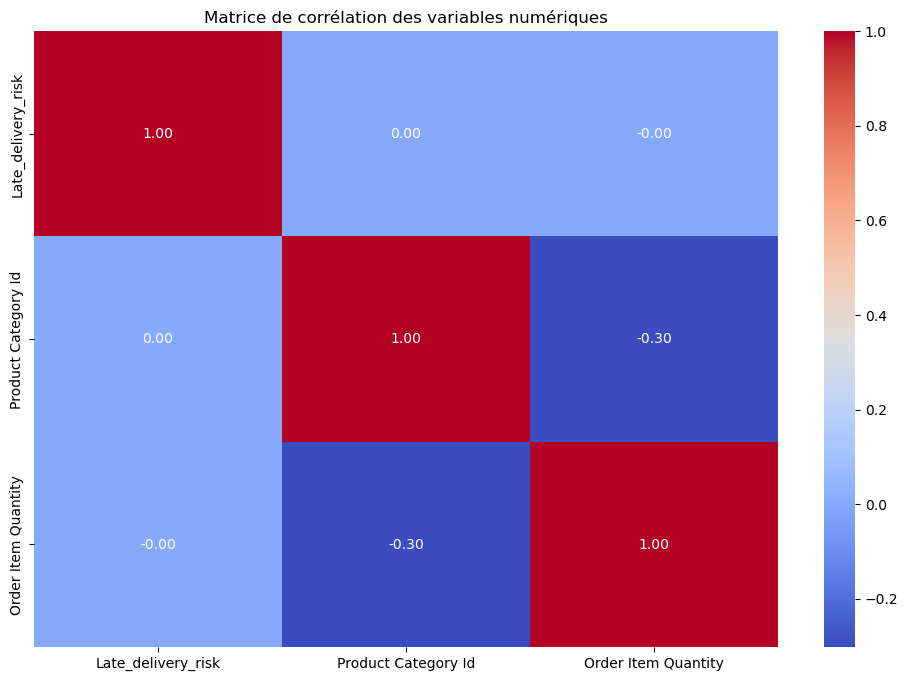

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


numeric_cols = [c for c, t in df.dtypes if t in ('int', 'double', 'float')]

pdf = df.select(numeric_cols).toPandas()

corr = pdf.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation des variables numériques")
plt.show()


In [9]:
from pyspark.sql.functions import sum

missing_counts = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])

missing_counts_filtered = missing_counts.select(
    [c for c in missing_counts.columns if missing_counts.first()[c] > 0]
)

missing_counts_filtered.show()

++
||
++
||
++



In [10]:
df = df.dropDuplicates()


IQR = 1.0, Thresholds: [-1.5, 2.5]
Nombre d'outliers for column Late_delivery_risk: 0


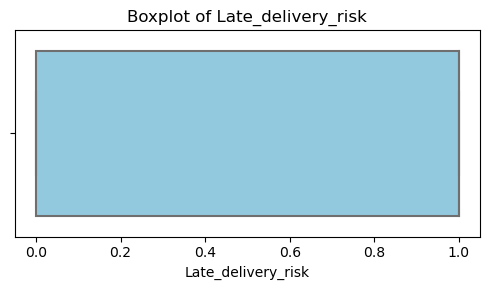

##################################################
IQR = 27.0, Thresholds: [-22.5, 85.5]
Nombre d'outliers for column Product Category Id: 0


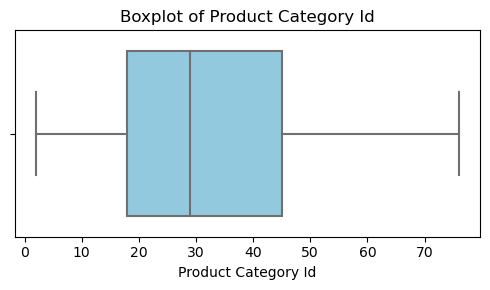

##################################################
IQR = 2.0, Thresholds: [-2.0, 6.0]
Nombre d'outliers for column Order Item Quantity: 0


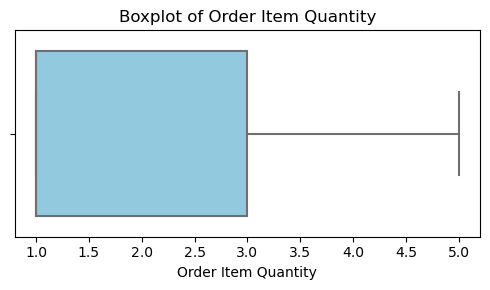

##################################################


In [11]:
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType
import matplotlib.pyplot as plt
import seaborn as sns


for c in df.columns:
    if not isinstance(df.schema[c].dataType, NumericType):
        continue

    quantiles = df.approxQuantile(c, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"IQR = {IQR}, Thresholds: [{lower_bound}, {upper_bound}]")

    outliers = df.filter((col(c) < lower_bound) | (col(c) > upper_bound))
    outlier_count = outliers.count()
    print(f"Nombre d'outliers for column {c}: {outlier_count}")
  
    sample_pd = df.select(c).toPandas()

    plt.figure(figsize=(5, 3))
    sns.boxplot(x=sample_pd[c], color="skyblue", fliersize=3)
    plt.title(f"Boxplot of {c}")
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()

    print('#' * 50)

In [12]:
df.show(10)

+--------+------------------+-------------------+-------------------+----------------+-------------+--------------+----------+-----------------------+--------------+
|    Type|Late_delivery_risk|Product Category Id|Order Item Quantity|Customer Country|Customer City| Order Country|Order City|order date (DateOrders)| Shipping Mode|
+--------+------------------+-------------------+-------------------+----------------+-------------+--------------+----------+-----------------------+--------------+
|   DEBIT|                 0|                 73|                  1|     Puerto Rico|       Caguas|     Indonesia|    Bekasi|        1/31/2018 22:56|Standard Class|
|    CASH|                 1|                 73|                  1|     Puerto Rico|       Caguas|         China| Guangzhou|        1/13/2018 10:00|  Second Class|
|   DEBIT|                 1|                 73|                  1|     Puerto Rico|       Caguas|         India|  Jabalpur|         1/13/2018 6:30|   First Class|
|TRA

In [13]:
from pyspark.sql.functions import to_timestamp ,month

df = df.withColumn("order_datetime", to_timestamp("order date (DateOrders)", "M/d/yyyy H:mm"))

df = df.withColumn("order_month", month("order_datetime"))
df = df.drop("order date (DateOrders)","order_datetime")


In [14]:
df.show(20)


+--------+------------------+-------------------+-------------------+----------------+-------------+--------------+--------------+--------------+-----------+
|    Type|Late_delivery_risk|Product Category Id|Order Item Quantity|Customer Country|Customer City| Order Country|    Order City| Shipping Mode|order_month|
+--------+------------------+-------------------+-------------------+----------------+-------------+--------------+--------------+--------------+-----------+
|   DEBIT|                 0|                 73|                  1|     Puerto Rico|       Caguas|     Indonesia|        Bekasi|Standard Class|          1|
|    CASH|                 1|                 73|                  1|     Puerto Rico|       Caguas|         China|     Guangzhou|  Second Class|          1|
|   DEBIT|                 1|                 73|                  1|     Puerto Rico|       Caguas|         India|      Jabalpur|   First Class|          1|
|TRANSFER|                 1|                 73|   

In [15]:
# import requests
# from requests.adapters import HTTPAdapter
# from urllib3.util.retry import Retry
# from pyspark.sql import Row

# # ----------------------------------
# # Create requests session (with retry)
# # ----------------------------------
# def create_session():
#     session = requests.Session()
#     retries = Retry(
#         total=5,
#         backoff_factor=0.5,
#         status_forcelist=[429, 500, 502, 503, 504],
#         allowed_methods=["GET"]
#     )
#     adapter = HTTPAdapter(max_retries=retries)
#     session.mount("https://", adapter)
#     session.mount("http://", adapter)
#     return session

# session = create_session()
# API_KEY = "b36185c337a14a57ba7ce5a36e5bfffc"

# # ----------------------------------
# # Function to fetch coordinates
# # ----------------------------------
# def fetch_coords(city, country):
#     try:
#         url = f"https://api.geoapify.com/v1/geocode/search?city={city}&country={country}&apiKey={API_KEY}"
#         response = session.get(url, timeout=10)
#         data = response.json()
#         features = data.get("features", [])
#         if features:
#             props = features[0]["properties"]
#             return (city, country), (props.get("lat", 0.0), props.get("lon", 0.0))
#         return (city, country), (0.0, 0.0)
#     except:
#         return (city, country), (0.0, 0.0)

# # ----------------------------------
# # Step 1: Extract distinct city/country pairs
# # ----------------------------------
# locations = df.select("Order City", "Order Country").distinct().collect()
# location_pairs = [(row["Order City"], row["Order Country"]) for row in locations]

# # ----------------------------------
# # Step 2: Fetch coordinates sequentially
# # ----------------------------------
# coords_map = {}
# for city, country in location_pairs:
#     key, coords = fetch_coords(city, country)
#     coords_map[key] = coords
#     print(city, country, "->", coords)

# print("Fetched:", len(coords_map), "coordinates")

# # ----------------------------------
# # Step 3: Create a new DataFrame from coordinates
# # ----------------------------------
# coords_rows = [Row(city=k[0], country=k[1], New_Latitude=v[0], New_Longitude=v[1])
#                for k, v in coords_map.items()]
# coords_df = spark.createDataFrame(coords_rows)

# # ----------------------------------
# # Step 4: Join coordinates DataFrame with original DataFrame
# # ----------------------------------
# df = df.join(
#     coords_df,
#     (df["Order City"] == coords_df["city"]) &
#     (df["Order Country"] == coords_df["country"]),
#     how="left"
# ).drop("city", "country")




In [16]:
# df.show(5)

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer_type = StringIndexer(inputCol="Type", outputCol="TypeIndex")
indexer_orderCountry = StringIndexer(inputCol="Order Country", outputCol="OrderCountryIndex")
indexer_orderCity = StringIndexer(inputCol="Order City", outputCol="OrderCityIndex")
indexer_shippingMode = StringIndexer(inputCol="Shipping Mode", outputCol="ShippingModeIndex")
indexer_customerCountry = StringIndexer(inputCol="Customer Country", outputCol="CustomerCountryIndex")
indexer_customerCity = StringIndexer(inputCol="Customer City", outputCol="CustomerCityIndex")

from pyspark.ml import Pipeline

encoding_pipeline = Pipeline(stages=[indexer_type,indexer_orderCountry, indexer_orderCity,indexer_shippingMode,indexer_customerCountry,indexer_customerCity])
df_indexed = encoding_pipeline.fit(df).transform(df)

df_indexed.write().overwrite().save("../models/encoding_model")

df_indexed = df_indexed.drop("Order Country", "Order City","Shipping Mode","Customer Country","Customer City","Type")





In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

target_col = "Late_delivery_risk"   
feature_cols = [c for c in df_indexed.columns if c != target_col]


assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

train_df, test_df = df_indexed.randomSplit([0.8, 0.2], seed=42)


rf = RandomForestClassifier(
    featuresCol="scaledFeatures",  
    labelCol="Late_delivery_risk",
    numTrees=100,                  
    maxDepth=5,                    
    seed=42
)

pipeline = Pipeline(stages=[assembler, scaler, rf])



In [22]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="Late_delivery_risk",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 7]) \
    .build()

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2
)

cv_model = crossval.fit(train_df)


In [23]:
predictions = cv_model.transform(test_df)

predictions.select("Late_delivery_risk", "prediction", "probability").show(7)


+------------------+----------+--------------------+
|Late_delivery_risk|prediction|         probability|
+------------------+----------+--------------------+
|                 0|       0.0|[0.61552985820851...|
|                 0|       0.0|[0.62593266796219...|
|                 0|       0.0|[0.61242864980888...|
|                 0|       0.0|[0.61416314732367...|
|                 0|       1.0|[0.17001260045613...|
|                 0|       0.0|[0.59238866554813...|
|                 0|       0.0|[0.60265496339815...|
+------------------+----------+--------------------+
only showing top 7 rows



In [24]:
auc = evaluator.evaluate(predictions)
print(f"AUC-ROC on test set: {auc:.4f}")

AUC-ROC on test set: 0.7461


In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="Late_delivery_risk", predictionCol="prediction", metricName="accuracy"
)
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="Late_delivery_risk", predictionCol="prediction", metricName="weightedPrecision"
)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="Late_delivery_risk", predictionCol="prediction", metricName="weightedRecall"
)
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="Late_delivery_risk", predictionCol="prediction", metricName="f1"
)

accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.6932
Precision: 0.7263
Recall: 0.6932
F1-score: 0.6917


In [26]:
predictions.groupBy("Late_delivery_risk", "prediction").count().show()


+------------------+----------+-----+
|Late_delivery_risk|prediction|count|
+------------------+----------+-----+
|                 1|       1.0|10874|
|                 0|       0.0|11874|
|                 1|       0.0| 7638|
|                 0|       1.0| 2431|
+------------------+----------+-----+



In [27]:
model_path = "./models/best_model"


cv_model.bestModel.write().overwrite().save(model_path)
print("Model saved successfully!")


Model saved successfully!
